In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
from pathlib import Path

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Dense, Dropout, Conv1D, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [4]:
def reduce_memory_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe is: {start_mem:.2f} MB")

    for col in df.columns:
        if df[col].dtype == "float64":
            df[col] = pd.to_numeric(df[col], downcast="float")
        elif df[col].dtype == "int64":
            df[col] = pd.to_numeric(df[col], downcast="integer")
        elif df[col].dtype == "object":
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory usage after optimization is: {end_mem:.2f} MB")

    return df


In [24]:
# Global variables
encoder_map = {}
forecast_horizon = 28
lookback_window = 7
model_path = str(
    Path().cwd().parent / "models" / "sales_forecast_model.h5"
)

df_path = str(
    Path().cwd().parent / "dataset" / "processed" / "processed_sales_data.csv"
)
df = pd.read_csv(df_path)
df = reduce_memory_usage(df)


Memory usage of dataframe is: 1112.51 MB
Memory usage after optimization is: 461.78 MB


In [25]:
df.drop(columns=["Unnamed: 0"], inplace=True)

FEATURES = [cols for cols in df.columns if cols not in ['log_sales', 'sales']]
TARGET = "sales"

# Feature Scaling
SCALE_FEATURES = [
    "sell_price",
    "lag_7",
    "lag_14",
    "lag_28",
    "rolling_mean_7",
    "rolling_std_7",
    "rolling_mean_14",
    "rolling_std_14",
    "rolling_mean_28",
    "rolling_std_28",
    "rolling_mean_56",
    "rolling_std_56",
    "expanding_mean",
    "price_change_pct",
    "rolling_price_std_4w",
]
scaler = MinMaxScaler()
df[SCALE_FEATURES] = scaler.fit_transform(df[SCALE_FEATURES])


# Prep as Time series
df.sort_values(["item_id", "year", "month", "wday"], inplace=True)

# Encoding categorical features
cat_features = ["item_id", "dept_id", "cat_id"]
for col in cat_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoder_map[col] = le

# Convert bool to int8
booleans = df.select_dtypes(include=["bool"]).columns
df[booleans] = df[booleans].astype("int8")

#HACK : to avoid memory issue
# Use only part of the data for training
reduced_df = df[df["year"] == 2016]

In [26]:
# Train-test split
train_df, test_df = train_test_split(reduced_df, test_size=0.2, random_state=42, shuffle=False)

# Define input features and target
X_train = train_df[FEATURES].values
y_train = train_df[TARGET].values
X_test = test_df[FEATURES].values
y_test = test_df[TARGET].values


In [27]:
# Generate sequences
train_gen = TimeseriesGenerator(
    X_train, y_train, length=lookback_window, batch_size=128
)

val_gen = TimeseriesGenerator(X_test, y_test, length=lookback_window, batch_size=128)

In [28]:
model = Sequential(
    [
        Conv1D(
            filters=64,
            kernel_size=3,
            activation="relu",
            input_shape=(lookback_window, len(FEATURES)),
        ),
        BatchNormalization(),
        LSTM(64, return_sequences=False),
        Dropout(0.3),
        Dense(32, activation="relu"),
        Dense(1), 
    ]
)
# Out: predicted sales value 

model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=["mae"])

/home/delen007/miniconda3/envs/walle/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(model_path, save_best_only=True),
    # ModelCheckpoint("best_lstm_model.h5", save_best_only=True),
]

history = model.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=callbacks)

Epoch 1/50


/home/delen007/miniconda3/envs/walle/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2192/2192 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 38.2883 - mae: 2.5016

2192/2192 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 38.2861 - mae: 2.5016 - val_loss: 6.2947 - val_mae: 1.2055
Epoch 2/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 33.2482 - mae: 2.3050 - val_loss: 6.5528 - val_mae: 1.5639
Epoch 3/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 29.4661 - mae: 2.4777 - val_loss: 7.0807 - val_mae: 1.7982
Epoch 4/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 28.4159 - mae: 2.4722 - val_loss: 7.5020 - val_mae: 1.9448
Epoch 5/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 24.5970 - mae: 2.4625 - val_loss: 7.8184 - val_mae: 2.0512
Epoch 6/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 34.0991 - mae: 2.6788 - val_loss: 7.9557 - val_mae: 2.0939


548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MAPE: 2420779127930880.0000
RMSE: 2.5089


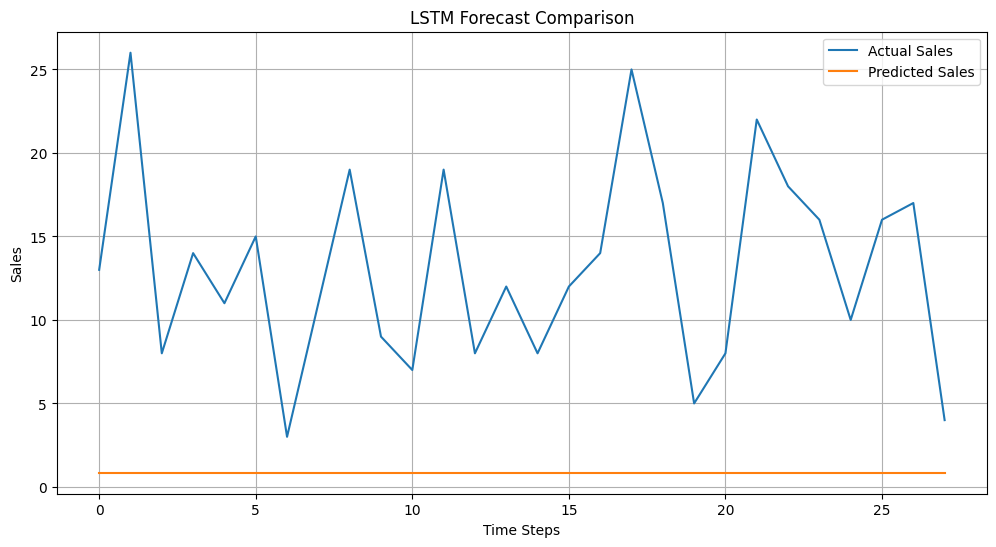

In [34]:
# Metric evaluation
preds = model.predict(val_gen)
sales = y_test[lookback_window:]

mape = mean_absolute_percentage_error(sales, preds)
rmse = np.sqrt(mean_squared_error(sales, preds))

print(f"MAPE: {mape:.4f}")
print(f"RMSE: {rmse:.4f}")

# Plot comparision 
plt.figure(figsize=(12, 6))
plt.plot(range(forecast_horizon), sales[:forecast_horizon], label="Actual Sales")
plt.plot(range(forecast_horizon), preds[:forecast_horizon], label="Predicted Sales")
plt.title("LSTM Forecast Comparison")
plt.xlabel("Time Steps")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model_path = str(Path().cwd().parent / "models" / "lstm_sales_model.h5")
model.save(model_path)